In [0]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
   
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    
    return layer_out

In [0]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def DeepResNetInception(input_shape = (150, 150, 3), classes = 6):   
    # Define the input 
    X_input = Input(input_shape)
        
    # No Padding Applied (ResNet-50 applied 7x7 Padding)
    X = X_input
    
    # Stage 1 - Strided Convolution (16 filters)
    X = Conv2D(16, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)

    # Stage 2 - Strided Convolution (32 filters)
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)

    
    # Stage 3 - Strided Convolution (64 filters)
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
    X = Activation('relu')(X)
  

    # Stage 4 - Inception Module (out 128)
    X = inception_module(X, f1=32, f2_in=(32+8), f2_out=64, f3_in=8, f3_out=16, f4_out=16)
    X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)
    X = Activation('relu')(X)    

    
    # Stage 5 - Residual Block (128, 128, 256)
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 256], stage=5, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv5')(X)
    X = Activation('relu')(X)    
    
    
    # Stage 6 - Inception Module (out 256)
    X = inception_module(X, f1=64, f2_in=(64+16), f2_out=128, f3_in=16, f3_out=32, f4_out=32)
    X = BatchNormalization(axis = 3, name = 'bn_conv6')(X)
    X = Activation('relu')(X)    

    
    # Stage 7 - Residual Block (256, 256, 512)
    X = convolutional_block(X, f = 3, filters = [256, 256, 512], stage = 7, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 512], stage=7, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv7')(X)
    X = Activation('relu')(X)
    
    
    # Stage 8 - Inception Module (out 512)
    X = inception_module(X, f1=128, f2_in=(128+32), f2_out=256, f3_in=32, f3_out=64, f4_out=64)
    X = BatchNormalization(axis = 3, name = 'bn_conv8')(X)
    X = Activation('relu')(X)    

    
    # Stage 9 - Residual Block (512, 512, 1024)
    X = convolutional_block(X, f = 3, filters = [512, 512, 1024], stage = 9, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 1024], stage=9, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv9')(X)
    X = Activation('relu')(X)    

    
    # Global Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    
    # Output Layer
    X = Flatten()(X)
    #X = Dropout(0.25)(X)
    
    X = Dense(classes, activation='softmax', name='fc' + str(classes),  kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Model Creation
    model = Model(inputs = X_input, outputs = X, name='DeepRes-ception')

    return model

In [0]:
model.summary()

Model: "DeepRes-ception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 74, 74, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 74, 74, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 74, 74, 16)   0           bn_conv1[0][0]                   
____________________________________________________________________________________

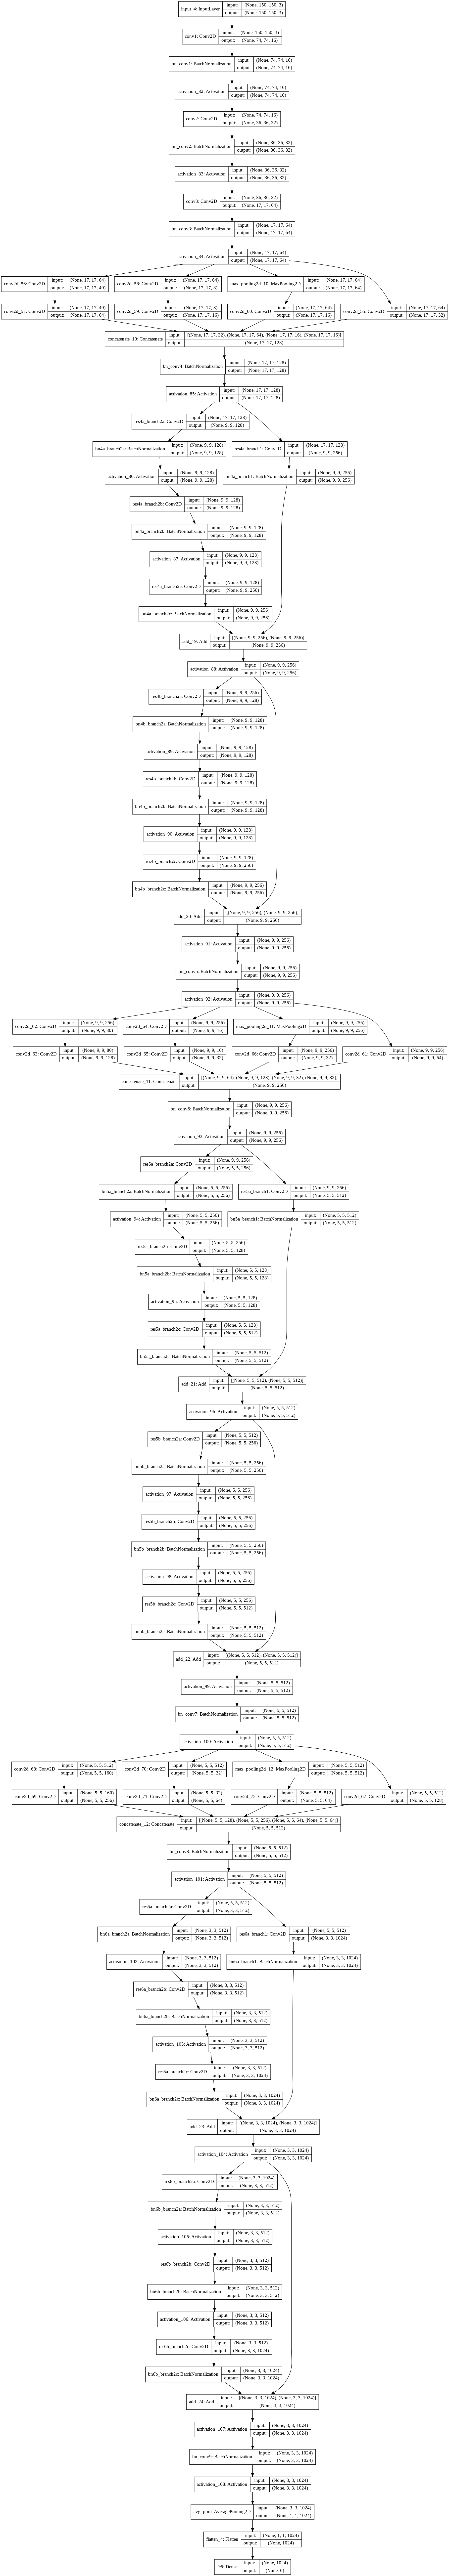

In [0]:
plot_model(model, show_shapes=True, to_file='Deep-Res-ception_model.png')